PCA降维

In [68]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 1. 数据加载与合并
# 加载数据集
prices_data = pd.read_csv('prices-split-adjusted.csv')
fundamentals_data = pd.read_csv('fundamentals.csv')
securities_data = pd.read_csv('securities.csv')

# 合并价格数据和财务数据
merged_data = pd.merge(prices_data, fundamentals_data, left_on=['symbol', 'date'], right_on=['Ticker Symbol', 'Period Ending'], how='inner')

# 合并公司行业信息
merged_data = pd.merge(merged_data, securities_data, left_on='symbol', right_on='Ticker symbol', how='inner')

In [69]:
# 2. 处理缺失值
# 检查每个特征的缺失值
print("每个特征的缺失值数量：")
print(merged_data.isnull().sum())

# 选择所有需要的特征（保留所有的特征）
X = merged_data.drop(['symbol', 'date', 'Ticker Symbol', 'Period Ending'], axis=1)  # 删除不需要的列

# 2.1 将数据分为数值型和非数值型数据
X_numeric = X.select_dtypes(include=['float64', 'int64'])  # 数值型数据
X_categorical = X.select_dtypes(include=['object'])  # 非数值型数据

# 2.2 对数值型数据进行均值填充
imputer_numeric = SimpleImputer(strategy='mean')
X_numeric_imputed = imputer_numeric.fit_transform(X_numeric)

# 2.3 对非数值型数据进行处理（如填充缺失值或进行编码）
# 对非数值型数据进行填充
imputer_categorical = SimpleImputer(strategy='most_frequent')
X_categorical_imputed = imputer_categorical.fit_transform(X_categorical)

# 2.4 对非数值型数据进行编码（如果必要）
# 对所有类别变量进行标签编码（可选）
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in X_categorical.columns:
    le = LabelEncoder()
    X_categorical_imputed[:, X_categorical.columns.get_loc(col)] = le.fit_transform(X_categorical_imputed[:, X_categorical.columns.get_loc(col)])
    label_encoders[col] = le

# 2.5 合并填充和编码后的数据
X_imputed = np.hstack([X_numeric_imputed, X_categorical_imputed])

# 3. 标准化数值型数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 4. 应用PCA降维（保留90%的方差）
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_scaled)

# 输出PCA解释方差比例
print(f"解释的方差比例: {pca.explained_variance_ratio_}")

# 5. 生成目标变量：股票的涨跌方向
merged_data['direction'] = merged_data['close'].diff().apply(lambda x: 1 if x > 0 else 0)
merged_data = merged_data.dropna(subset=['direction'])

# 6. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_pca, merged_data['direction'], test_size=0.2, random_state=42)

每个特征的缺失值数量：
date                         0
symbol                       0
open                         0
close                        0
low                          0
                          ... 
GICS Sector                  0
GICS Sub Industry            0
Address of Headquarters      0
Date first added           552
CIK                          0
Length: 94, dtype: int64
解释的方差比例: [0.24893845 0.10570058 0.05450422 0.04754789 0.04325033 0.03969937
 0.03417176 0.03254849 0.02866555 0.02773396 0.02248849 0.02208243
 0.01976831 0.01677662 0.01522778 0.01426027 0.01397941 0.01316234
 0.01228588 0.01192079 0.01180928 0.01121707 0.01090738 0.01040853
 0.00982569 0.0094027  0.00887131 0.00836141]


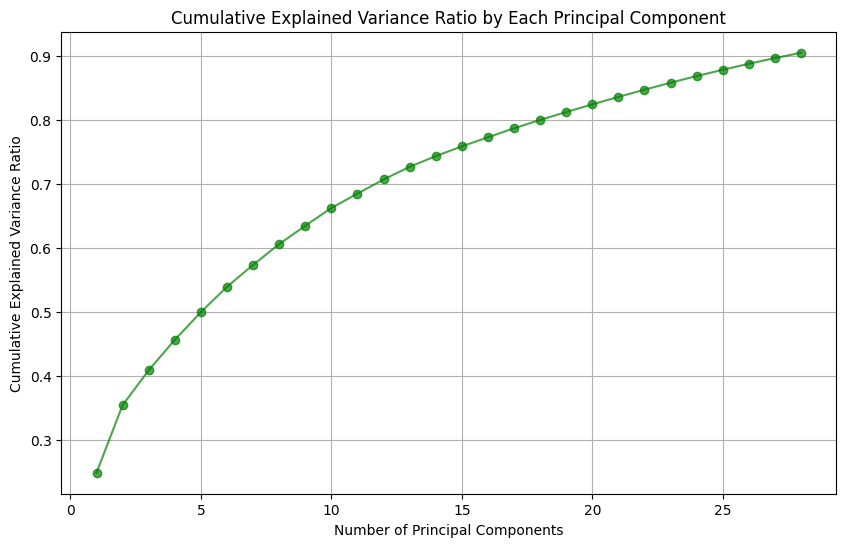

In [70]:
# 计算累计解释的方差比例
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 可视化PCA的累计解释方差比例（折线图）
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='g', linestyle='-', alpha=0.7)
plt.title("Cumulative Explained Variance Ratio by Each Principal Component")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.grid(True)
plt.show()


In [71]:
# 1. 原始特征数量
original_features = X_scaled.shape[1]  # X_scaled 的列数即为原始特征数量
print(f"原始特征数量: {original_features}")

# 2. 选取的主成分数量
n_selected_components = len(np.cumsum(pca.explained_variance_ratio_))  # 或者直接看pca.components_的行数
print(f"选取的主成分数量: {n_selected_components}")

# 3. 查看累计解释的方差比例
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"累计解释的方差比例: {cumulative_variance}")


原始特征数量: 90
选取的主成分数量: 28
累计解释的方差比例: [0.24893845 0.35463904 0.40914326 0.45669115 0.49994149 0.53964086
 0.57381261 0.60636111 0.63502666 0.66276062 0.68524911 0.70733154
 0.72709985 0.74387647 0.75910425 0.77336452 0.78734393 0.80050627
 0.81279214 0.82471293 0.83652221 0.84773928 0.85864665 0.86905519
 0.87888088 0.88828358 0.89715489 0.9055163 ]


逻辑回归

准确率: 0.7169117647058824
混淆矩阵:
[[114  33]
 [ 44  81]]
精确度: 0.7105263157894737
召回率: 0.648
F1分数: 0.6778242677824268


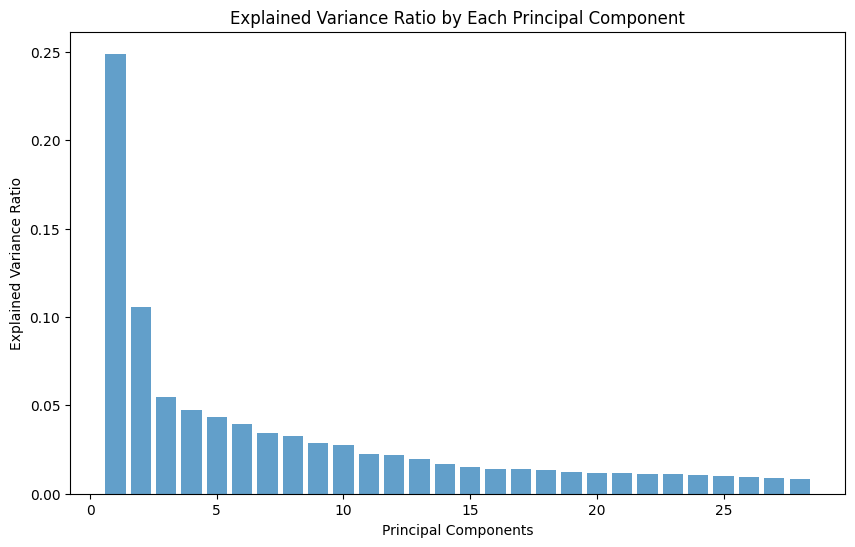

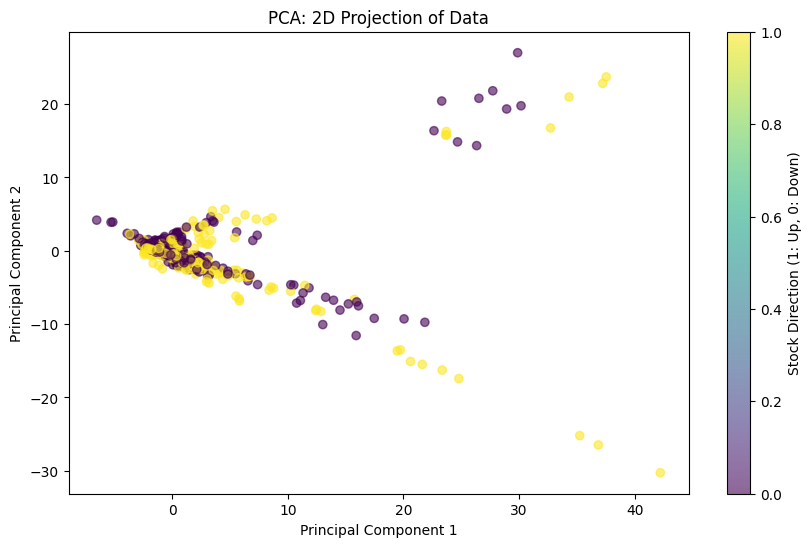

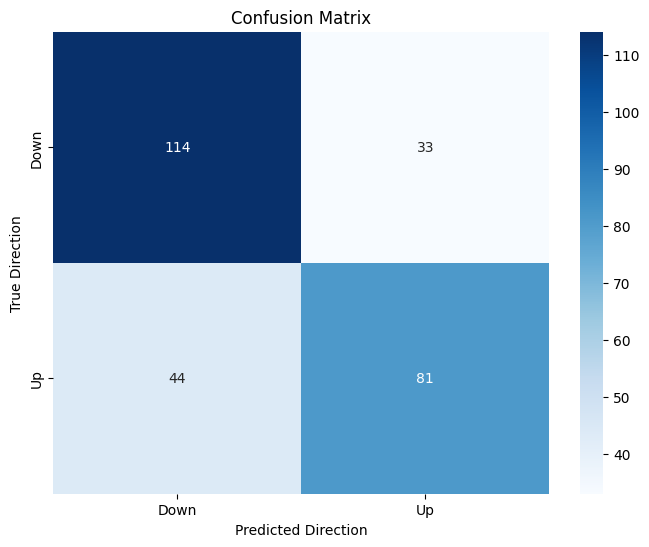

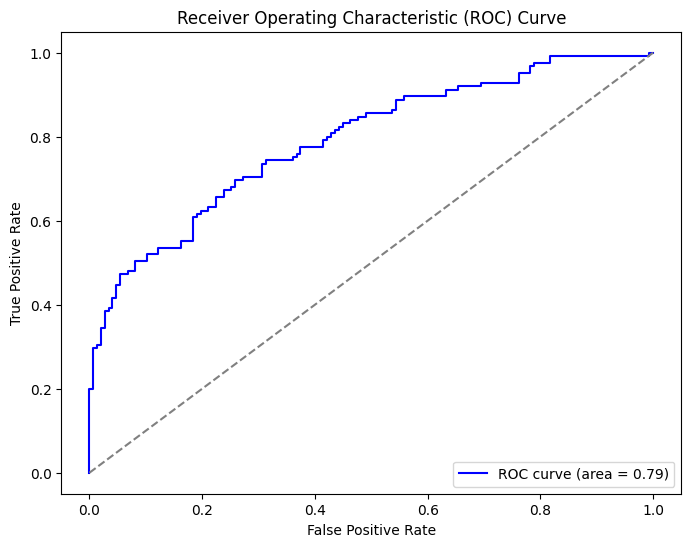

In [72]:
# 7. 训练逻辑回归模型
model = LogisticRegression()
model.fit(X_train, y_train)

# 8. 预测与评估模型
y_pred = model.predict(X_test)

# 评估模型
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 输出评估结果
print(f"准确率: {accuracy}")
print(f"混淆矩阵:\n{conf_matrix}")
print(f"精确度: {precision}")
print(f"召回率: {recall}")
print(f"F1分数: {f1}")

# 9. 可视化PCA降维的解释方差比例
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7)
plt.title("Explained Variance Ratio by Each Principal Component")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.show()

# 10. 可视化PCA降维后的2D散点图
X_pca_2d = X_pca[:, :2]  # 选择前两个主成分进行可视化

plt.figure(figsize=(10, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=merged_data['direction'], cmap='viridis', alpha=0.6)
plt.title("PCA: 2D Projection of Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Stock Direction (1: Up, 0: Down)')
plt.show()

# 11. 可视化混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Direction")
plt.ylabel("True Direction")
plt.show()

# 12. 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

随机森林

随机森林准确率: 0.8235294117647058
随机森林混淆矩阵:
[[127  20]
 [ 28  97]]
随机森林精确度: 0.8290598290598291
随机森林召回率: 0.776
随机森林F1分数: 0.8016528925619835


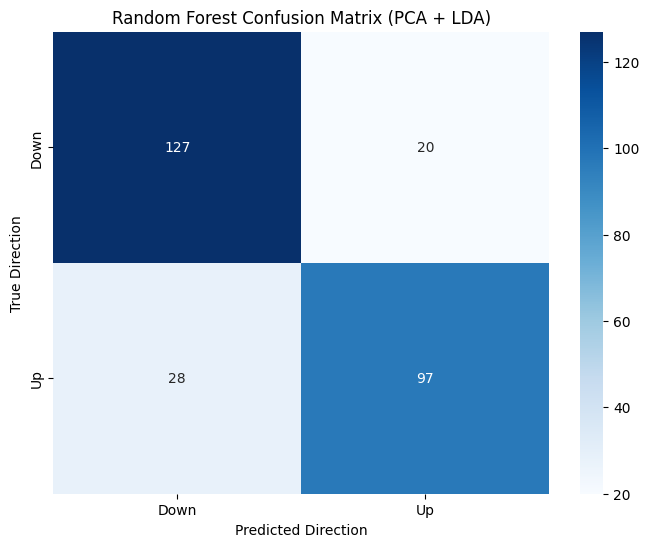

In [73]:
# 使用随机森林模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 6. 预测与评估模型（随机森林）
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"随机森林准确率: {accuracy_rf}")
print(f"随机森林混淆矩阵:\n{conf_matrix_rf}")
print(f"随机森林精确度: {precision_rf}")
print(f"随机森林召回率: {recall_rf}")
print(f"随机森林F1分数: {f1_rf}")

# 可视化随机森林的混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.title("Random Forest Confusion Matrix (PCA + LDA)")
plt.xlabel("Predicted Direction")
plt.ylabel("True Direction")
plt.show()

XGBoost模型

XGBoost准确率: 0.8235294117647058
XGBoost混淆矩阵:
[[121  26]
 [ 22 103]]
XGBoost精确度: 0.7984496124031008
XGBoost召回率: 0.824
XGBoostF1分数: 0.8110236220472441


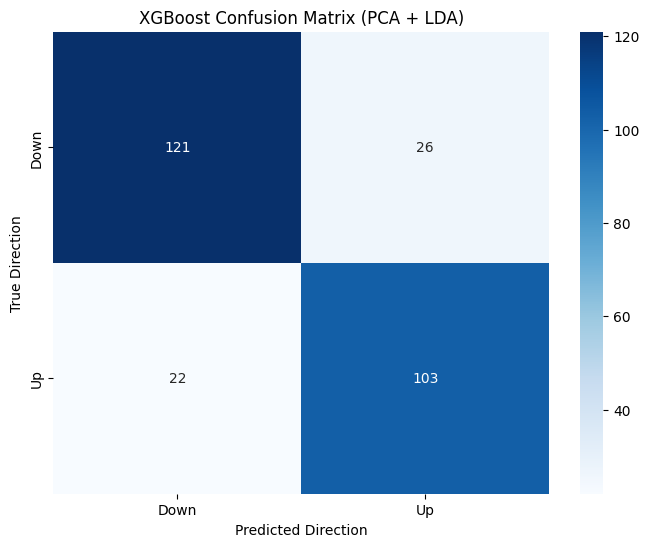

In [74]:
# 使用XGBoost模型
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# 7. 预测与评估模型（XGBoost）
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"XGBoost准确率: {accuracy_xgb}")
print(f"XGBoost混淆矩阵:\n{conf_matrix_xgb}")
print(f"XGBoost精确度: {precision_xgb}")
print(f"XGBoost召回率: {recall_xgb}")
print(f"XGBoostF1分数: {f1_xgb}")

# 可视化XGBoost的混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.title("XGBoost Confusion Matrix (PCA + LDA)")
plt.xlabel("Predicted Direction")
plt.ylabel("True Direction")
plt.show()

SVM模型

SVM准确率: 0.7205882352941176
SVM混淆矩阵:
[[116  31]
 [ 45  80]]
SVM精确度: 0.7207207207207207
SVM召回率: 0.64
SVMF1分数: 0.6779661016949152


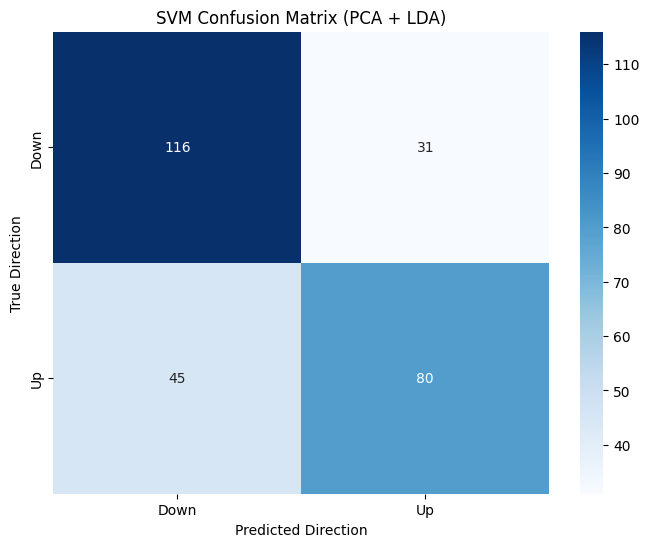

In [75]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 使用SVM模型
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# 预测与评估模型
y_pred_svm = svm_model.predict(X_test)

# 输出评估结果
accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print(f"SVM准确率: {accuracy_svm}")
print(f"SVM混淆矩阵:\n{conf_matrix_svm}")
print(f"SVM精确度: {precision_svm}")
print(f"SVM召回率: {recall_svm}")
print(f"SVMF1分数: {f1_svm}")

# 可视化SVM的混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.title("SVM Confusion Matrix (PCA + LDA)")
plt.xlabel("Predicted Direction")
plt.ylabel("True Direction")
plt.show()

KNN模型

KNN准确率: 0.7389705882352942
KNN混淆矩阵:
[[111  36]
 [ 35  90]]
KNN精确度: 0.7142857142857143
KNN召回率: 0.72
KNNF1分数: 0.7171314741035857


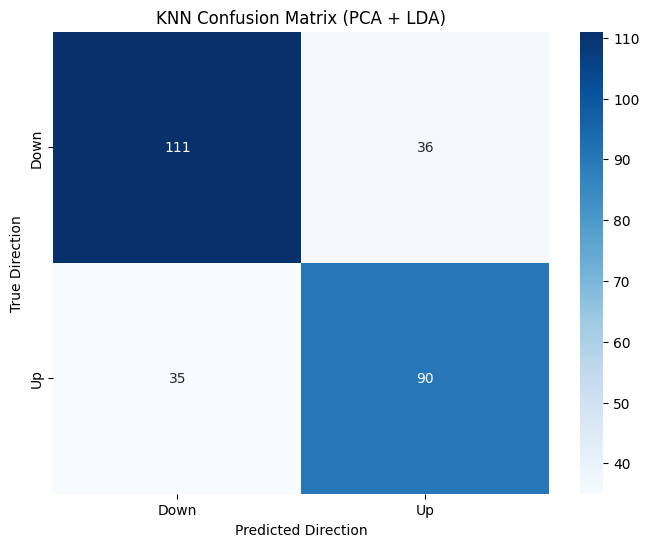

In [76]:
from sklearn.neighbors import KNeighborsClassifier

# 使用KNN模型
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# 预测与评估模型
y_pred_knn = knn_model.predict(X_test)

# 输出评估结果
accuracy_knn = accuracy_score(y_test, y_pred_knn)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

print(f"KNN准确率: {accuracy_knn}")
print(f"KNN混淆矩阵:\n{conf_matrix_knn}")
print(f"KNN精确度: {precision_knn}")
print(f"KNN召回率: {recall_knn}")
print(f"KNNF1分数: {f1_knn}")

# 可视化KNN的混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.title("KNN Confusion Matrix (PCA + LDA)")
plt.xlabel("Predicted Direction")
plt.ylabel("True Direction")
plt.show()


PCA之后LDA

准确率: 0.7242647058823529
混淆矩阵:
[[121  26]
 [ 49  76]]
精确度: 0.7450980392156863
召回率: 0.608
F1分数: 0.6696035242290749


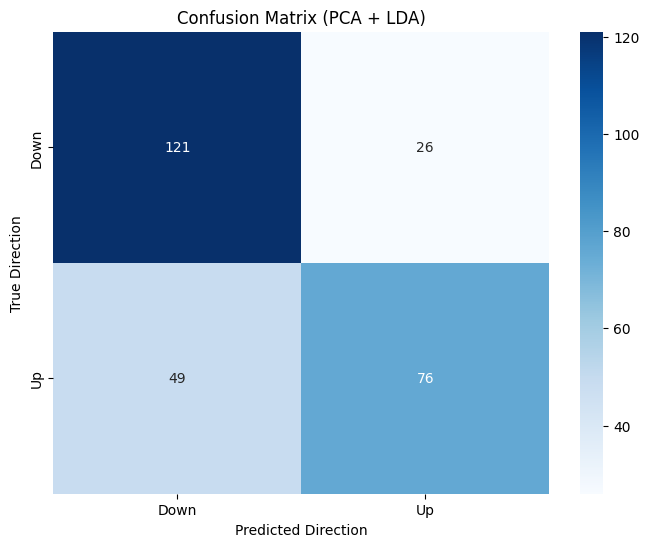

In [60]:
# 导入必要的库
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 1. 数据加载与合并
# 加载数据集
prices_data = pd.read_csv('prices-split-adjusted.csv')
fundamentals_data = pd.read_csv('fundamentals.csv')
securities_data = pd.read_csv('securities.csv')

# 合并价格数据和财务数据
merged_data = pd.merge(prices_data, fundamentals_data, left_on=['symbol', 'date'], right_on=['Ticker Symbol', 'Period Ending'], how='inner')

# 合并公司行业信息
merged_data = pd.merge(merged_data, securities_data, left_on='symbol', right_on='Ticker symbol', how='inner')

# 生成目标变量：股票的涨跌方向
merged_data['direction'] = merged_data['close'].diff().apply(lambda x: 1 if x > 0 else 0)
merged_data = merged_data.dropna(subset=['direction'])

# 2. 处理缺失值
X = merged_data.drop(['symbol', 'date', 'Ticker Symbol', 'Period Ending', 'direction'], axis=1)
y = merged_data['direction']

# 2.1 分离数值型和非数值型数据
X_numeric = X.select_dtypes(include=['float64', 'int64'])  # 数值型数据
X_categorical = X.select_dtypes(include=['object'])  # 非数值型数据

# 2.2 对数值型数据进行均值填充
imputer_numeric = SimpleImputer(strategy='mean')
X_numeric_imputed = imputer_numeric.fit_transform(X_numeric)

# 2.3 对非数值型数据进行填充（最频繁值）
imputer_categorical = SimpleImputer(strategy='most_frequent')
X_categorical_imputed = imputer_categorical.fit_transform(X_categorical)

# 2.4 对非数值型数据进行编码
label_encoders = {}
for col in X_categorical.columns:
    le = LabelEncoder()
    X_categorical_imputed[:, X_categorical.columns.get_loc(col)] = le.fit_transform(X_categorical_imputed[:, X_categorical.columns.get_loc(col)])
    label_encoders[col] = le

# 2.5 合并数值型和非数值型数据
X_imputed = np.hstack([X_numeric_imputed, X_categorical_imputed])

# 3. 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 4. 使用PCA进行降维
pca = PCA(n_components=5)  # 选择降到5个主成分
X_pca = pca.fit_transform(X_scaled)

# 5. 使用LDA进行分类
lda = LinearDiscriminantAnalysis()
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# 训练LDA模型
lda.fit(X_train, y_train)

# 6. 预测与评估模型
y_pred = lda.predict(X_test)

# 输出评估结果
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"准确率: {accuracy}")
print(f"混淆矩阵:\n{conf_matrix}")
print(f"精确度: {precision}")
print(f"召回率: {recall}")
print(f"F1分数: {f1}")

# 7. 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.title("Confusion Matrix (PCA + LDA)")
plt.xlabel("Predicted Direction")
plt.ylabel("True Direction")
plt.show()


LDA降维

每个特征的缺失值数量：
date                         0
symbol                       0
open                         0
close                        0
low                          0
                          ... 
GICS Sub Industry            0
Address of Headquarters      0
Date first added           552
CIK                          0
direction                    0
Length: 95, dtype: int64
LDA降维后的数据维度: (1357, 1)


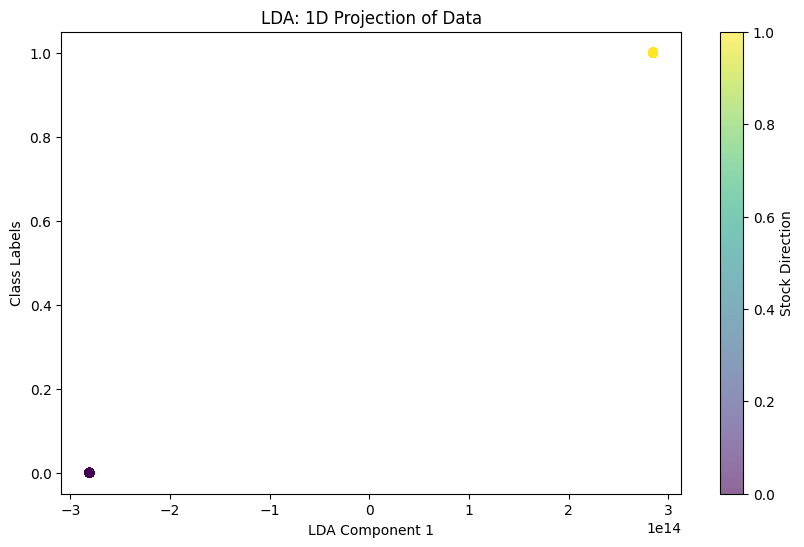

准确率: 1.0
混淆矩阵:
[[147   0]
 [  0 125]]
精确度: 1.0
召回率: 1.0
F1分数: 1.0


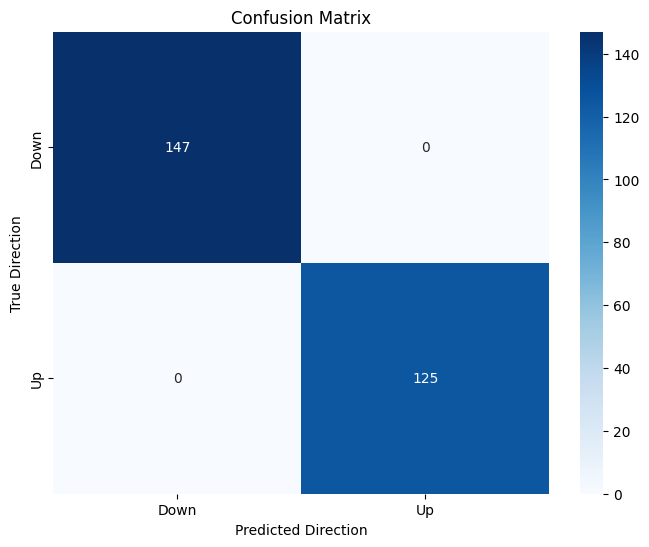

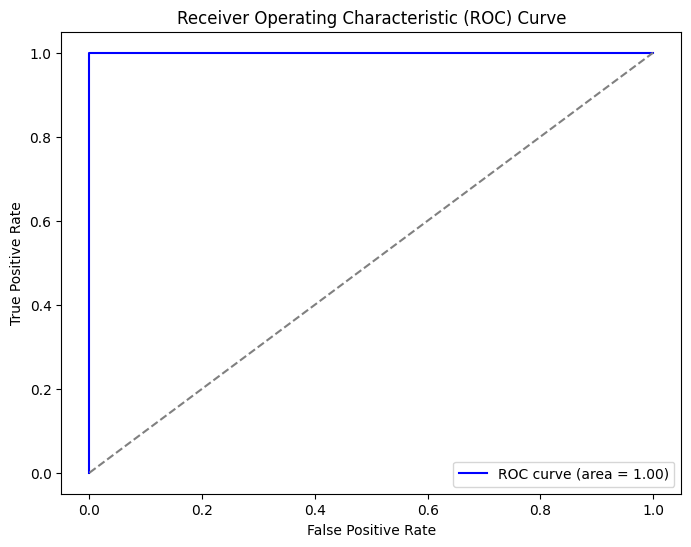

In [55]:
# 导入必要的库
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer

# 1. 数据加载与合并
# 加载数据集
prices_data = pd.read_csv('prices-split-adjusted.csv')
fundamentals_data = pd.read_csv('fundamentals.csv')
securities_data = pd.read_csv('securities.csv')

# 合并价格数据和财务数据
merged_data = pd.merge(prices_data, fundamentals_data, left_on=['symbol', 'date'], right_on=['Ticker Symbol', 'Period Ending'], how='inner')

# 合并公司行业信息
merged_data = pd.merge(merged_data, securities_data, left_on='symbol', right_on='Ticker symbol', how='inner')

# 生成目标变量：股票的涨跌方向
merged_data['direction'] = merged_data['close'].diff().apply(lambda x: 1 if x > 0 else 0)

# 确保没有NaN值的行
merged_data = merged_data.dropna(subset=['direction'])

# 2. 处理缺失值
# 检查每个特征的缺失值
print("每个特征的缺失值数量：")
print(merged_data.isnull().sum())

# 选择所有需要的特征（保留所有的特征）
X = merged_data.drop(['symbol', 'date', 'Ticker Symbol', 'Period Ending'], axis=1)  # 删除不需要的列

# 将数据分为数值型和非数值型数据
X_numeric = X.select_dtypes(include=['float64', 'int64'])  # 数值型数据
X_categorical = X.select_dtypes(include=['object'])  # 非数值型数据

# 对数值型数据进行均值填充
imputer_numeric = SimpleImputer(strategy='mean')
X_numeric_imputed = imputer_numeric.fit_transform(X_numeric)

# 对非数值型数据进行填充
imputer_categorical = SimpleImputer(strategy='most_frequent')
X_categorical_imputed = imputer_categorical.fit_transform(X_categorical)

# 对非数值型数据进行编码
label_encoders = {}
for col in X_categorical.columns:
    le = LabelEncoder()
    X_categorical_imputed[:, X_categorical.columns.get_loc(col)] = le.fit_transform(X_categorical_imputed[:, X_categorical.columns.get_loc(col)])
    label_encoders[col] = le

# 合并填充和编码后的数值型和非数值型数据
X_imputed = np.hstack([X_numeric_imputed, X_categorical_imputed])

# 3. 标准化数值型数据
# 这里只标准化数值型数据
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric_imputed)

# 4. 使用LDA进行降维
# LDA只能在有多个类别的情况下使用，所以需要确保类别标签足够
lda = LinearDiscriminantAnalysis(n_components=min(X_numeric_scaled.shape[1], len(np.unique(merged_data['direction']))-1))  # 选择合适的主成分数
X_lda = lda.fit_transform(X_numeric_scaled, merged_data['direction'])

# 输出LDA降维后的数据
print(f"LDA降维后的数据维度: {X_lda.shape}")

# 可视化LDA降维后的数据
plt.figure(figsize=(10, 6))
plt.scatter(X_lda[:, 0], merged_data['direction'], c=merged_data['direction'], cmap='viridis', alpha=0.6)
plt.title(f"LDA: {X_lda.shape[1]}D Projection of Data")
plt.xlabel(f"LDA Component 1")
plt.ylabel("Class Labels")
plt.colorbar(label='Stock Direction')
plt.show()

# 5. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_lda, merged_data['direction'], test_size=0.2, random_state=42)

# 6. 训练逻辑回归模型
model = LogisticRegression()
model.fit(X_train, y_train)

# 7. 预测与评估模型
y_pred = model.predict(X_test)

# 评估模型
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 输出评估结果
print(f"准确率: {accuracy}")
print(f"混淆矩阵:\n{conf_matrix}")
print(f"精确度: {precision}")
print(f"召回率: {recall}")
print(f"F1分数: {f1}")

# 8. 可视化混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Direction")
plt.ylabel("True Direction")
plt.show()

# 9. 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


每个特征的缺失值数量：
date                         0
symbol                       0
open                         0
close                        0
low                          0
                          ... 
GICS Sub Industry            0
Address of Headquarters      0
Date first added           552
CIK                          0
direction                    0
Length: 95, dtype: int64
QDA准确率: 1.0
QDA混淆矩阵:
[[147   0]
 [  0 125]]
QDA精确度: 1.0
QDA召回率: 1.0
QDA F1分数: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


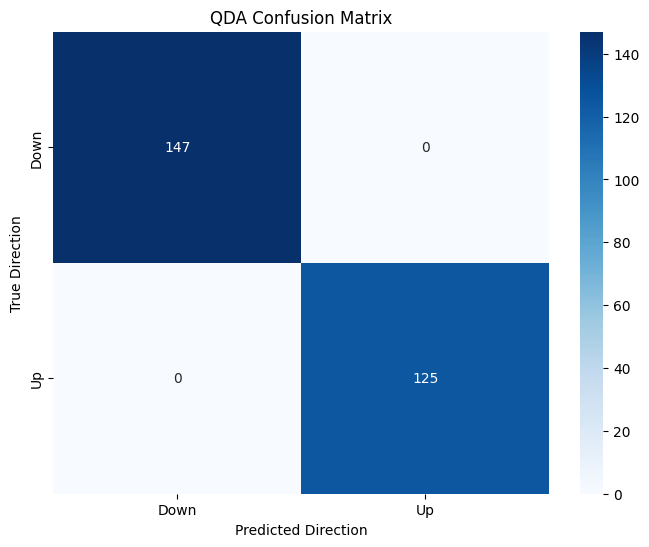

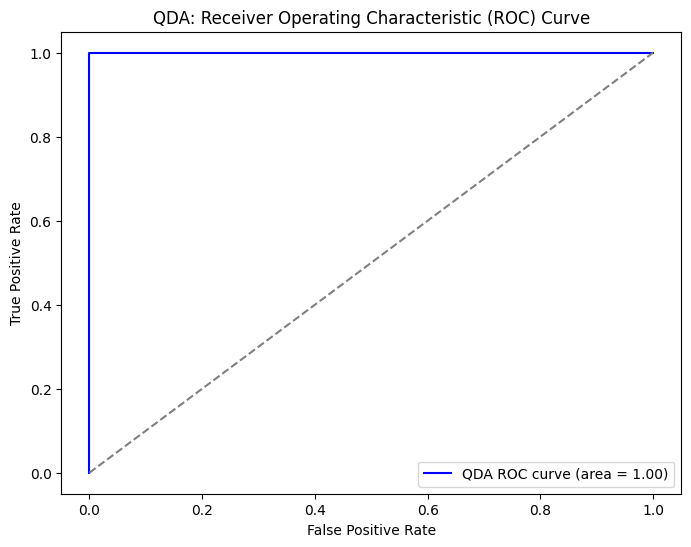

In [58]:
# 导入必要的库
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer

# 1. 数据加载与合并
# 加载数据集
prices_data = pd.read_csv('prices-split-adjusted.csv')
fundamentals_data = pd.read_csv('fundamentals.csv')
securities_data = pd.read_csv('securities.csv')

# 合并价格数据和财务数据
merged_data = pd.merge(prices_data, fundamentals_data, left_on=['symbol', 'date'], right_on=['Ticker Symbol', 'Period Ending'], how='inner')

# 合并公司行业信息
merged_data = pd.merge(merged_data, securities_data, left_on='symbol', right_on='Ticker symbol', how='inner')

# 生成目标变量：股票的涨跌方向
merged_data['direction'] = merged_data['close'].diff().apply(lambda x: 1 if x > 0 else 0)

# 确保没有NaN值的行
merged_data = merged_data.dropna(subset=['direction'])

# 2. 处理缺失值
# 检查每个特征的缺失值
print("每个特征的缺失值数量：")
print(merged_data.isnull().sum())

# 选择所有需要的特征（保留所有的特征）
X = merged_data.drop(['symbol', 'date', 'Ticker Symbol', 'Period Ending'], axis=1)  # 删除不需要的列

# 将数据分为数值型和非数值型数据
X_numeric = X.select_dtypes(include=['float64', 'int64'])  # 数值型数据
X_categorical = X.select_dtypes(include=['object'])  # 非数值型数据

# 对数值型数据进行均值填充
imputer_numeric = SimpleImputer(strategy='mean')
X_numeric_imputed = imputer_numeric.fit_transform(X_numeric)

# 对非数值型数据进行填充
imputer_categorical = SimpleImputer(strategy='most_frequent')
X_categorical_imputed = imputer_categorical.fit_transform(X_categorical)

# 对非数值型数据进行编码
label_encoders = {}
for col in X_categorical.columns:
    le = LabelEncoder()
    X_categorical_imputed[:, X_categorical.columns.get_loc(col)] = le.fit_transform(X_categorical_imputed[:, X_categorical.columns.get_loc(col)])
    label_encoders[col] = le

# 合并填充和编码后的数值型和非数值型数据
X_imputed = np.hstack([X_numeric_imputed, X_categorical_imputed])

# 3. 标准化数值型数据
# 这里只标准化数值型数据
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric_imputed)

# 4. 使用QDA进行建模
# 创建QDA模型
qda = QuadraticDiscriminantAnalysis()

# 5. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_numeric_scaled, merged_data['direction'], test_size=0.2, random_state=42)

# 6. 训练QDA模型
qda.fit(X_train, y_train)

# 7. 预测与评估模型
y_pred_qda = qda.predict(X_test)

# 评估模型
accuracy_qda = accuracy_score(y_test, y_pred_qda)
conf_matrix_qda = confusion_matrix(y_test, y_pred_qda)
precision_qda = precision_score(y_test, y_pred_qda)
recall_qda = recall_score(y_test, y_pred_qda)
f1_qda = f1_score(y_test, y_pred_qda)

# 输出评估结果
print(f"QDA准确率: {accuracy_qda}")
print(f"QDA混淆矩阵:\n{conf_matrix_qda}")
print(f"QDA精确度: {precision_qda}")
print(f"QDA召回率: {recall_qda}")
print(f"QDA F1分数: {f1_qda}")

# 8. 可视化混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_qda, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.title("QDA Confusion Matrix")
plt.xlabel("Predicted Direction")
plt.ylabel("True Direction")
plt.show()

# 9. 绘制ROC曲线
fpr_qda, tpr_qda, _ = roc_curve(y_test, qda.predict_proba(X_test)[:, 1])
roc_auc_qda = auc(fpr_qda, tpr_qda)

plt.figure(figsize=(8, 6))
plt.plot(fpr_qda, tpr_qda, color='b', label=f'QDA ROC curve (area = {roc_auc_qda:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("QDA: Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()
